In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import numpy as np
from models import create_model
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchsummary import summary
from ptoa.tsetranslate.model import UBlock, ULayer
from ptoa.data.knee_monai import KneeDataset, Knee, SliceDataset
from data.knee_dataset import PixSliceTranslateDataset, MoonCometBoneInpaintDataset
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from models.pix2pix_model import Pix2PixModel
import skimage.filters
import random
import monai

import tqdm
import glob
import ants

In [3]:
### PLOT FNS

R,G,B = 0,1,2

def make_rgb(img):
    out = np.zeros([3] + list(img.shape))
    out[:,:,:] = img
    return out

def add_mask(img, mask, c='r', alpha=0.2):
    if c == 'r': # RED
        rgb = [R]
    elif c == 'g': # GREEN
        rgb = [G]
    elif c == 'b': # BLUE
        rgb = [B]
    elif c == 'c': # CYAN
        rgb = [G,B]
    elif c == 'm': # MAGENTA
        rgb = [B,R]
    elif c == 'y': # YELLOW
        rgb = [R,G]
    else:
        raise ValueError('c must be one of [r,g,b,c,m,y]')
    img[rgb,:,:] += (mask * alpha)
    return img

def scale(img, min_q=0., max_q=1., new_min=None, new_max=None):
    min_val = np.quantile(img, min_q)
    max_val = np.quantile(img, max_q)
    if new_min is None:
        new_min = min_val
    if new_max is None:
        new_max = max_val
    img = np.clip(img, min_val, max_val)
    img = img / (max_val - min_val) * (new_max - new_min)
    img = img - img.min() + new_min
    return img

def subplots(cols=1, figsize=7.5):
    fig, ax = plt.subplots(1, cols, figsize=(cols * figsize, figsize))
    return fig, ax

def plots(imgs, cp=None, title=None, axtitles=None, cbar=True, figsize=7.5, reorient=True, axis=True):
    if not isinstance(imgs, (list, tuple)):
        imgs = [imgs]
    n_axes = len(imgs)
    if axtitles is None:
        axtitles = [None] * n_axes
    elif not isinstance(axtitles, (list, tuple)):
        axtitles = [axtitles]

    axis = 'on' if axis else 'off'

    fig, ax = subplots(n_axes, figsize)
    if n_axes == 1:
        ax = [ax]
    fig.suptitle(title)
    # fig.tight_layout()
    if cp is not None and reorient:
        cp = cp[1], cp[0]
    for i, img in enumerate(imgs):
        if isinstance(img, torch.Tensor):
            img = img.detach().cpu()
        if len(img.shape) == 3: # RGB
            if reorient:
                img = np.moveaxis(img, 0, -1)
            cmap = None
        else:
            cmap = 'gray'
        if reorient:
            img = np.fliplr(np.rot90(img, k=3))
        mat = ax[i].matshow(img, cmap=cmap)
        if cp is not None:
            ax[i].scatter(cp[0], cp[1], s=2_000, edgecolors='r', alpha=0.5, facecolors='none', linewidths=1.25)
        ax[i].set_title(axtitles[i]) #, fontdict={'size': 24})
        if cbar:
            plt.colorbar(mat, ax=ax[i])
        
        ax[i].axis(axis)
    return fig, ax

In [4]:
def dice(a, b, empty_as=1.):
    intersection = (a & b).sum()
    total = a.sum() + b.sum()
    if total == 0: return empty_as
    return 2. * intersection / total

## Load + Preprocess Images

In [5]:
kds = KneeDataset()
outliers = [
    'patient-ccf-51566-20211014-knee_contra', # min=-2 (looks pretty normal)
    'patient-ccf-001-20210917-knee', # max=1+ (looks pretty normal)
]
kds.knees = [k for k in kds.knees
                if k.base not in outliers
                and all(k.path[x] is not None for x in ['IMG_TSE', 'DESS2TSE', 'BONE_TSE'])
            ][:20]
ds = SliceDataset(knees=kds.knees, img_size=320)

SliceDataset.tx: 100%|██████████| 20/20 [00:08<00:00,  2.28it/s]


In [6]:
knees_bmel = [k for k in kds.knees if k.path['BMELT'] is not None]
knees_nobmel = [k for k in kds.knees if k.path['BMELT'] is None]
slc_bmel = [d for d in ds if d['base'] in [k.base for k in knees_bmel] and d['BMELT'].sum() > 0]
# nobmel slc from knees with bmel
slc_nobmel_k_bmel = [d for d in ds if d['base'] in [k.base for k in knees_bmel] and d['BMELT'].sum() == 0]
slc_nobmel = [d for d in ds if d['base'] in [k.base for k in knees_nobmel]]
# ds_bmel = PixSliceTranslateDataset(slices=slc_bmel)
# ds_nobmel = PixSliceTranslateDataset(slices=slc_nobmel)
ds_bmel = MoonCometBoneInpaintDataset(slices=slc_bmel)
ds_nobmel = MoonCometBoneInpaintDataset(slices=slc_nobmel)
dl_bmel = DataLoader(ds_bmel)
dl_nobmel = DataLoader(ds_nobmel)
print(len(knees_bmel), len(knees_nobmel))
print(len(ds_bmel), len(ds_nobmel), len(slc_nobmel_k_bmel), len(ds))

3 17
43 449 26 518


In [7]:
ds_bmel[0]['A'].shape

torch.Size([1, 320, 320])

## Load pretrained models

In [8]:
import ast
# name = 'dess2tse_128_5'
epoch = 600
name = 'boneinpaint'
epoch = 1000

f = open(f'./checkpoints/{name}/train_opt.txt', 'r')
opt = [l.strip().split()[:2] for l in f][1:-1]
opt = [o + [''] if len(o) == 1  else o for o in opt]
for o in opt:
    if o[0] == 'gpu_ids:':
        str_ids = o[1].split(',')
        o[1] = []
        for str_id in str_ids:
            id = int(str_id)
            if id >= 0:
                o[1].append(id)
    else:
        try:
            o[1] = ast.literal_eval(o[1])
        except:
            pass
opt = {o[0][:-1]:o[1] for o in opt}
opt = argparse.Namespace(**opt)
opt.isTrain = False
opt.epoch = epoch

In [9]:
opt

Namespace(batch_size=96, beta1=0.5, checkpoints_dir='./checkpoints', continue_train=False, crop_size=256, dataroot='NULL', dataset_mode='aligned', direction='AtoB', display_env='main', display_freq=400, display_id=1, display_ncols=4, display_port=8097, display_server='http://localhost', display_winsize=256, epoch=1000, epoch_count=1, gan_mode='vanilla', gpu_ids=[2], init_gain=0.02, init_type='normal', input_nc=1, isTrain=False, lambda_L1=100.0, load_iter=0, load_size=286, lr=0.0002, lr_decay_iters=50, lr_policy='linear', max_dataset_size='inf', model='pix2pix', n_epochs=500, n_epochs_decay=500, n_layers_D=5, name='boneinpaint', ndf=128, netD='n_layers', netG='unet_320', ngf=128, no_boneseg=False, no_dropout=False, no_flip=False, no_html=False, norm='batch', num_threads=4, output_nc=1, phase='train', pool_size=0, preprocess='resize_and_crop', print_freq=100, save_by_iter=False, save_epoch_freq=5, save_latest_freq=5000, serial_batches=False, suffix='', update_html_freq=1000, use_wandb=Fa

In [10]:
model = create_model(opt)
model.setup(opt)
model.eval()

initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/boneinpaint/1000_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 116.934 M
-----------------------------------------------


In [11]:
model_avg = create_model(opt)
model_avg.setup(opt)
model_avg.eval()

initialize network with normal
model [Pix2PixModel] was created
loading the model from ./checkpoints/boneinpaint/1000_net_G.pth
---------- Networks initialized -------------
[Network G] Total number of parameters : 116.934 M
-----------------------------------------------


## Get Mean Embeddings >:] of Healthy Images
- `model` uses sample embeddings
  - collects average embeddings, then passes them off
  - run slices through model, collect embeddings only
- `model_avg` uses average embeddings

In [12]:
if isinstance(model.hook_handle, torch.utils.hooks.RemovableHandle):
    model.hook_handle.remove()
model.hook_handle = model.get_embeddings()

In [13]:
for i, batch in enumerate(tqdm.tqdm(dl_nobmel)):
    model.set_input(batch)
    model.forward()

  0%|          | 0/449 [00:00<?, ?it/s]100%|██████████| 449/449 [00:11<00:00, 39.09it/s]


In [14]:
model.hook_handle.remove() # no need to collect embeddings anymore

In [15]:
f'embeddings (output of encoder): n={len(model.embeddings)}; shape={model.embeddings[0].shape}'

'embeddings (output of encoder): n=449; shape=torch.Size([1024])'

In [16]:
if isinstance(model_avg.hook_handle, torch.utils.hooks.RemovableHandle):
    model_avg.hook_handle.remove()
model_avg.hook_handle = model_avg.set_embeddings(embeddings=model.embeddings)

## Run predictions

In [17]:
dess_thresh = 0.99
epistemic_thresh = .9
n_montecarlo = 100
aleatoric_thresh = 1 - 1e-4
aleatoric_offset = 0.1
blur_sigma = 1.0
pred_thresh = .08

## for batch_ndx, batch in enumerate(tqdm.tqdm(dl_bmel)):
    # Run models
    model.set_input(batch)
    model_avg.set_input(batch)
    model.forward()
    model_avg.forward()

    real_dess = model.real_A[0,0].detach().cpu().numpy()
    fake_tse = model.fake_B[0,0].detach().cpu().numpy()
    fake_tse_avg = model_avg.fake_B[0,0].detach().cpu().numpy()
    real_tse = model.real_B[0,0].detach().cpu().numpy()
    real_dess = scale(real_dess, max_q=dess_thresh)
    bmel = (model.image_bmel[0,0] > 0).to(torch.float32).detach().cpu().numpy()
    bone_nodil = (model.image_bone[0,0] > 0).to(torch.float32).detach().cpu().numpy()

    # Epistemic = Real - Fake
    epistemic = real_tse - fake_tse
    epistemic = scale(epistemic, min_q=epistemic_thresh, new_min=0, new_max=1)
    
    epistemic_avg = real_tse - fake_tse_avg
    epistemic_avg = scale(epistemic_avg, min_q=epistemic_thresh, new_min=0, new_max=1)
    
    # Aleatoric = Bayesian Approx with Dropout
    for m in model_avg.netG.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

    fakes = []
    for i in range(n_montecarlo):
        model_avg.forward()
        fake_B = model_avg.fake_B[0,0]
        fakes.append(fake_B.detach().cpu())
    title = model.image_id[0]
    fakes = np.stack(fakes, axis=0)
    
    aleatoric = np.var(fakes, axis=0)
    aleatoric = scale(aleatoric, max_q=aleatoric_thresh, new_min=0. + aleatoric_offset, new_max=1. + aleatoric_offset)

    for m in model_avg.netG.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.eval()

    # Scibilic = Epistemic / Aleatoric
    scibilic = scale(epistemic_avg / aleatoric, new_min=0, new_max=1)
    scibilic = scibilic * bone_nodil

    scibilic_smooth = skimage.filters.gaussian(scibilic, sigma=blur_sigma)
    binary_scibilic = scibilic_smooth > pred_thresh

    # print(monai.metrics.compute_dice(torch.from_numpy(bmel), torch.from_numpy(binary_scibilic), include_background=False, ))
    print(dice(bmel.astype(bool), binary_scibilic.astype(bool)))
    # Compare with postproc
    overlay = make_rgb(scale(real_tse, new_min=0, new_max=1))
    overlay = add_mask(overlay, binary_scibilic.astype(bool) & bmel.astype(bool), c='g')
    overlay = add_mask(overlay, binary_scibilic.astype(bool) & ~bmel.astype(bool), c='y')
    overlay = add_mask(overlay, ~binary_scibilic.astype(bool) & bmel.astype(bool), c='r')

    title = model.image_id[0]
    fig, ax = plots(imgs=[real_dess, real_tse, fake_tse_avg, scibilic, overlay],
                    title=title,
                    axtitles=['Input (Real Input DESS)',
                              'Target (Real Input TSE)',
                              'Output (Fake Healthy TSE)',
                              'Model Prediction',
                            #   'Binary Prediction',
                            #   'Expert Annotation',
                              'Binary Prediction vs. Annotation'
                              ],
                    cbar=False, axis=False)
    legend_elements = [
        Line2D([0], [0], marker='s', color='none', label='True Positive', alpha=0.4,
                        markerfacecolor='g', markersize=15, ),
        Line2D([0], [0], marker='s', color='none', label='False Positive', alpha=0.4,
                        markerfacecolor='y', markersize=15, ),
        Line2D([0], [0], marker='s', color='none', label='False Negative', alpha=0.4,
                        markerfacecolor='r', markersize=15, ),
    ]
    ax[-1].legend(handles=legend_elements) #, prop={'size': 20})
    plt.show()
    # plt.savefig(f'/home/yua4/temp/pytorch-CycleGAN-and-pix2pix/results_pred/{title}.png')
    plt.close()

## Load pre-computed predictions

In [ ]:
names = ['dess2tse_128_3',  'dess2tse_128_5',  'dess2tse_64_3',  'dess2tse_myu_128_5',  'dess2tse_myu_64_5']
bmels = torch.load(f'/home/yua4/temp/pytorch-CycleGAN-and-pix2pix/results_pred/bmels.pt')
pred_threshes = np.arange(0.01, 0.50, 0.01)
dices = {}
for n in names:
    dices[n] = {}
    pred = torch.load(f'/home/yua4/temp/pytorch-CycleGAN-and-pix2pix/results_pred/{n}.pt')
    for pred_thresh in tqdm.tqdm(pred_threshes):
        pred_binary = pred > pred_thresh
        dices[n][pred_thresh] = []
        for slc_ndx in range(bmels.shape[0]):
            dices[n][pred_thresh].append(monai.metrics.compute_dice(bmels[slc_ndx], pred_binary[slc_ndx]))
        dices[n][pred_thresh] = torch.tensor(dices[n][pred_thresh]).nan_to_num().mean()
    
        ### WHY DOESN'T THIS WORK???
        # dices[n][pred_thresh] = torch.tensor([
        #     monai.metrics.compute_dice(bmels[slc_ndx], pred_binary[slc_ndx]) for slc_ndx in range(bmels.shape[0])
        # ]).nan_to_num().mean()

100%|██████████| 49/49 [00:11<00:00,  4.27it/s]


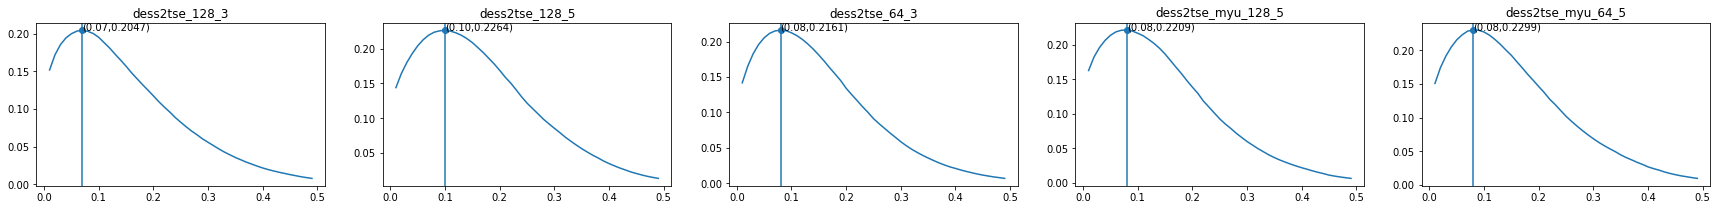

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(30,3))
for i, n in enumerate(names):
    argmax = max(dices[n], key=dices[n].get)
    valmax = dices[n][argmax]
    ax[i].scatter([argmax],[valmax])
    ax[i].text(argmax, valmax, f'({argmax:.2f},{valmax:.4f})')
    ax[i].axvline(max(dices[n], key=lambda k: dices[n][k]))
    ax[i].plot(dices[n].keys(), dices[n].values())
    ax[i].set_title(n)
plt.show()

In [ ]:
n = 'dess2tse_myu_64_5'
dice_max = 0
slc_max = -1
pred = torch.load(f'/home/yua4/temp/pytorch-CycleGAN-and-pix2pix/results_pred/{n}.pt')
for pred_thresh in tqdm.tqdm(pred_threshes):
    pred_binary = pred > pred_thresh
    for slc_ndx in range(bmels.shape[0]):
        d = monai.metrics.compute_dice(bmels[slc_ndx], pred_binary[slc_ndx]).nan_to_num()
        if d > dice_max:
            slc_max = slc_ndx


## Pick sample slice

In [ ]:
Knee('moon-patient-osu-51265-20210721-knee_injured').path

OrderedDict([('IMG_TSE',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-TSE.nii.gz'),
             ('IMG_DESS',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-DESS.nii.gz'),
             ('BMELT', None),
             ('BMELCP',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-BMELCP_TSE.nii.gz'),
             ('BONE_TSE',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-BONESEG_TSE.nii.gz'),
             ('BONE_DESS',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-BONESEG_DESS.nii.gz'),
             ('FBONE_DESS',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-FBONESEG_DESS.nii.gz'),
             ('TBONE_DESS',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-TBONESEG_DESS.nii.gz'),
             ('DESS2TSE',
              '/home/yua4/nifti/moon-patient-osu-51265-20210721-knee_injured-D

In [ ]:
kds_bmel = KneeDataset()
kds_bmel.knees = [Knee('comet-patient-ccf-001-20210601-knee')]
ds_bmel = PixSliceTranslateDataset(kds_bmel.knees , slc_has_bmel=True)
dl_bmel = DataLoader(ds_bmel, shuffle=True)
[s['id'] for s in ds_bmel]

100%|██████████| 1/1 [00:00<00:00,  1.23it/s]


['comet-patient-ccf-001-20210601-knee[9]',
 'comet-patient-ccf-001-20210601-knee[10]',
 'comet-patient-ccf-001-20210601-knee[11]',
 'comet-patient-ccf-001-20210601-knee[12]',
 'comet-patient-ccf-001-20210601-knee[13]',
 'comet-patient-ccf-001-20210601-knee[14]',
 'comet-patient-ccf-001-20210601-knee[16]',
 'comet-patient-ccf-001-20210601-knee[17]',
 'comet-patient-ccf-001-20210601-knee[18]',
 'comet-patient-ccf-001-20210601-knee[19]',
 'comet-patient-ccf-001-20210601-knee[20]',
 'comet-patient-ccf-001-20210601-knee[21]',
 'comet-patient-ccf-001-20210601-knee[22]',
 'comet-patient-ccf-001-20210601-knee[23]',
 'comet-patient-ccf-001-20210601-knee[24]',
 'comet-patient-ccf-001-20210601-knee[25]']

In [ ]:
dess_thresh = 0.98

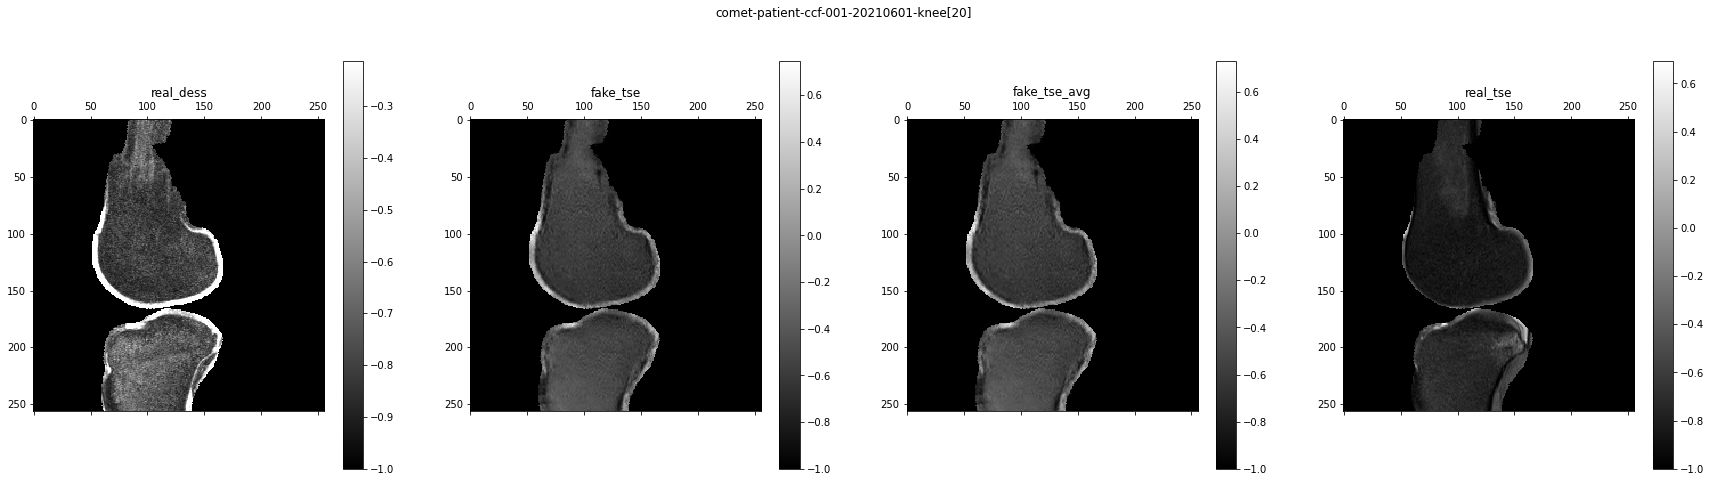

In [ ]:
# choose a good bmel slice
for batch in dl_bmel:
    if batch['id'][0] == 'comet-patient-ccf-001-20210601-knee[20]':
        model.set_input(batch)
        model_avg.set_input(batch)
        model.forward()
        model_avg.forward()
        break
    
real_dess = model.real_A[0, 0].detach().cpu()
fake_tse = model.fake_B[0,0].detach().cpu()
fake_tse_avg = model_avg.fake_B[0, 0].detach().cpu()
real_tse = model.real_B[0, 0].detach().cpu()
real_dess = scale(real_dess, max_q=dess_thresh)

fig, ax = plots([real_dess, fake_tse, fake_tse_avg, real_tse], axtitles=['real_dess', 'fake_tse', 'fake_tse_avg', 'real_tse'], cp=None, title=model.image_id[0])
plt.show()

# Epistemic Uncertainty (variance from normal)

In [ ]:
epistemic_thresh = .9

In [ ]:
epistemic = real_tse - fake_tse_avg
epistemic = scale(epistemic, min_q=epistemic_thresh, new_min=0, new_max=1)

# Aleatoric Uncertainty (variance within normal): using `model_avg`

## Control (MCDropout off)

In [ ]:
n_montecarlo = 100
aleatoric_thresh = 1 - 1e-4
aleatoric_offset = 0.1

In [ ]:
for m in model_avg.netG.modules():
    if m.__class__.__name__.startswith('Dropout'):
        m.eval()

100%|██████████| 100/100 [00:02<00:00, 48.55it/s]


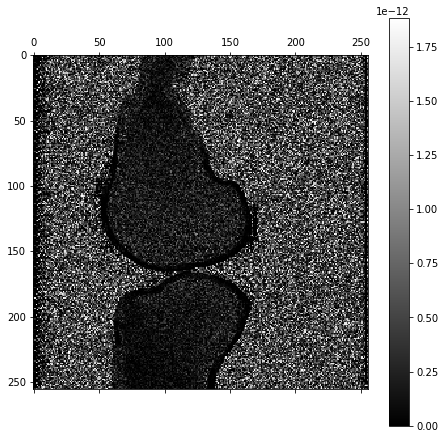

In [ ]:
# model or model_avg?
fakes = []
for i in tqdm.tqdm(range(n_montecarlo)):
    model_avg.forward()
    fake_B = model_avg.fake_B[0, 0]
    fakes.append(fake_B.detach().cpu())
fakes = np.stack(fakes, axis=0)
_ = plots([np.var(fakes, axis=0)])

## MCDropout on

In [ ]:
for m in model_avg.netG.modules():
    if m.__class__.__name__.startswith('Dropout'):
        m.train()

In [ ]:
fakes = []
for i in tqdm.tqdm(range(n_montecarlo)):
    model_avg.forward()
    fake_B = model_avg.fake_B[0,0]
    fakes.append(fake_B.detach().cpu())
fakes = np.stack(fakes, axis=0)
aleatoric = np.var(fakes, axis=0)
aleatoric = scale(aleatoric, max_q=aleatoric_thresh, new_min=0. + aleatoric_offset, new_max=1. + aleatoric_offset)

100%|██████████| 100/100 [00:02<00:00, 45.85it/s]


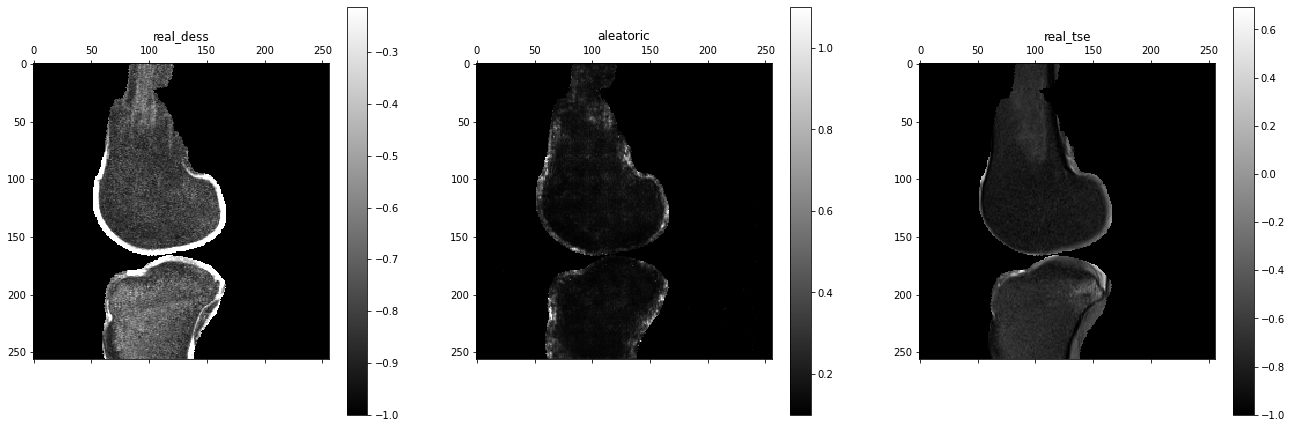

In [ ]:
fig, ax = plots([real_dess, aleatoric, real_tse], axtitles=['real_dess', 'aleatoric', 'real_tse'], cp=None,)
plt.show()

# Scibilic Uncertainty

In [ ]:
scibilic = scale(epistemic / aleatoric, new_min=0, new_max=1)

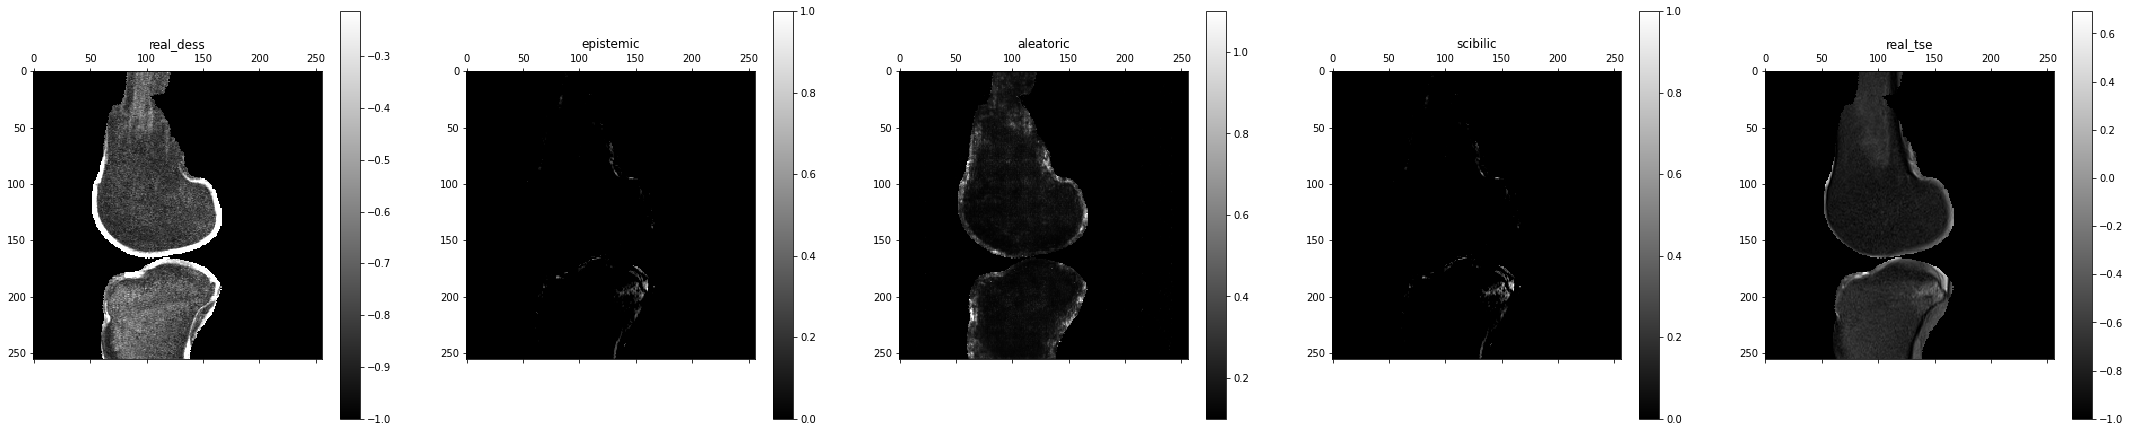

In [ ]:
fig, ax = plots([real_dess, epistemic, aleatoric, scibilic, real_tse], axtitles=['real_dess', 'epistemic', 'aleatoric', 'scibilic', 'real_tse'], cp=None,)
plt.show()

# Undo Bone Dilation
Cartilage mask not necessary (except erosion on the shafts; could use original bone masks instead)

In [ ]:
model.set_input_eroded(batch)
eroded_mask = (model.image_bone[0,0].detach().cpu().to(bool))
eroded_scibilic = scibilic.clone()
eroded_scibilic[~eroded_mask] = 0

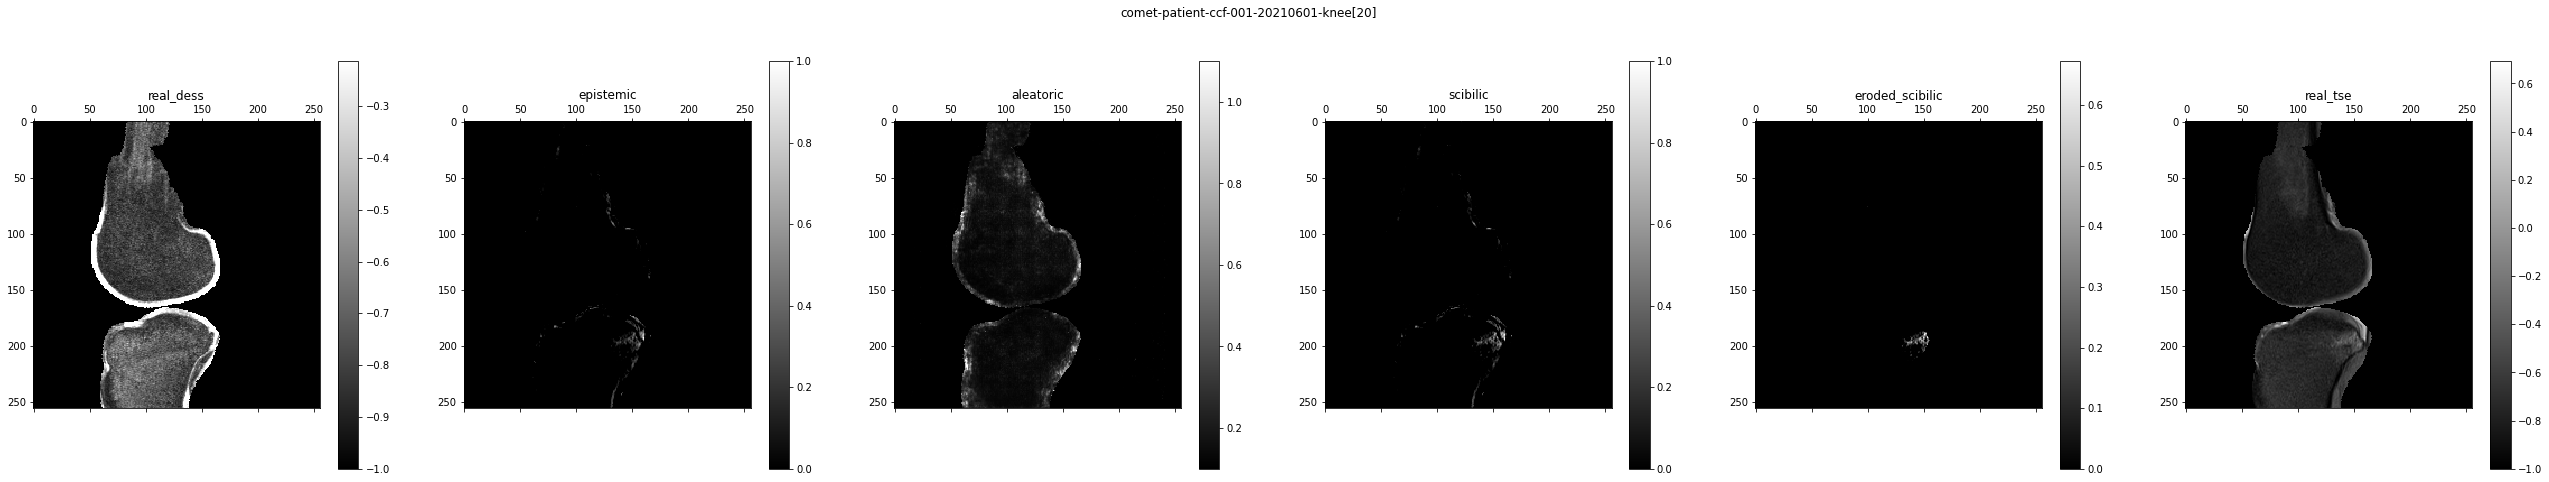

In [ ]:
fig, ax = plots([real_dess, epistemic, aleatoric, scibilic, eroded_scibilic, real_tse], title=model.image_id[0], axtitles=['real_dess', 'epistemic', 'aleatoric', 'scibilic', 'eroded_scibilic', 'real_tse'], cp=None,)
plt.show()

# Binarized Prediction

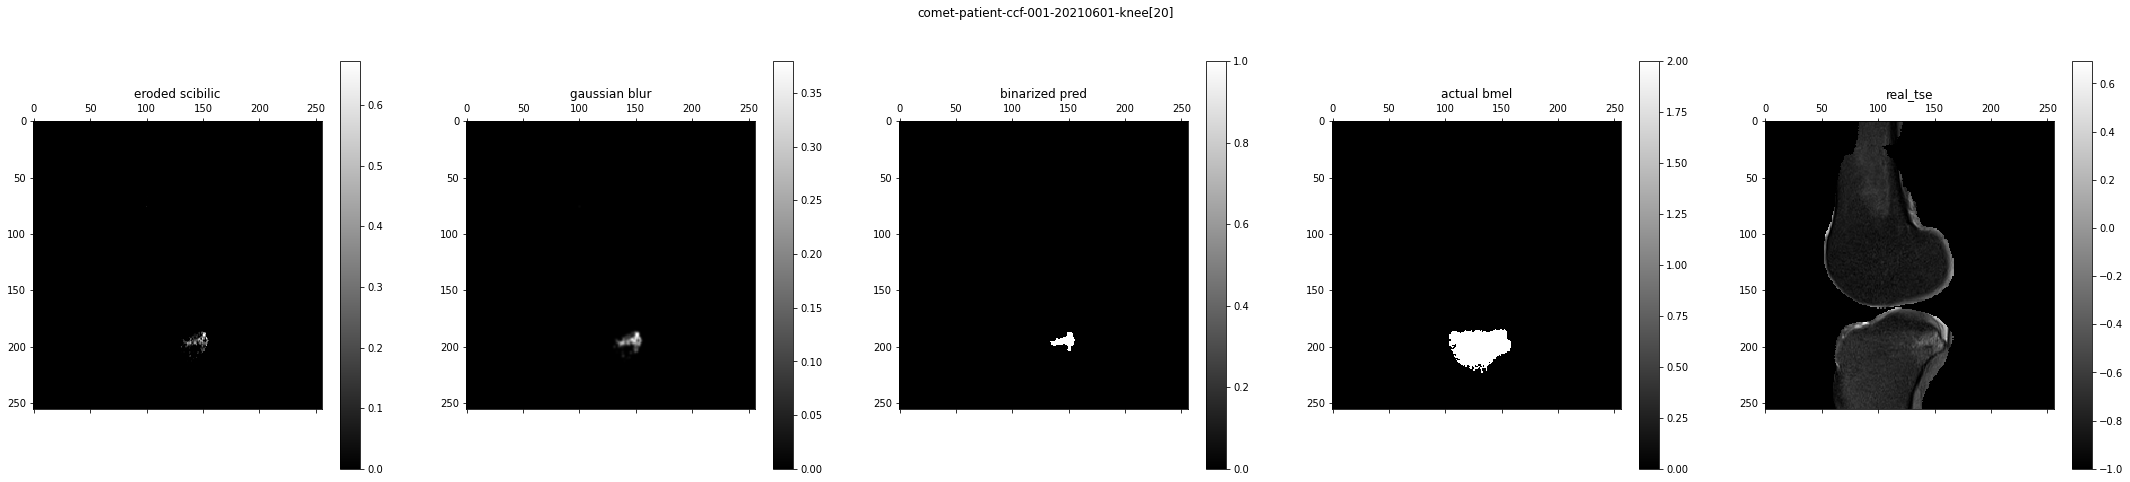

In [ ]:
from skimage import (
    filters, measure, morphology, segmentation
)
# morph.opening(eroded_scibilic, footprint=morph.disk(2))

scibilic_thresh = .1
blur_sigma = 1.0

eroded_scibilic_smooth = filters.gaussian(eroded_scibilic, sigma=blur_sigma)
binary_scibilic = eroded_scibilic_smooth > scibilic_thresh
fig, ax = plots([eroded_scibilic, eroded_scibilic_smooth, binary_scibilic, model.image_bmel[0][0], real_tse], title=model.image_id[0], axtitles=['eroded scibilic', 'gaussian blur', 'binarized pred', 'actual bmel', 'real_tse'], cp=None,)

# Compare to Labels

# TODO
## Training
* augmentation (esp. intensity range gradient)
* regularization / early stopping

## Morpho
with dilation, connected components, smoothing on scibilic to make bmelseg mask
## Check Labels
DICE curves

# Draw to File

In [ ]:
# from PIL import Image
# import glob
# paths = sorted(glob.glob(savedir + '*.png'))
# images = [Image.open(p) for p in paths]
# out = []
# for img in tqdm.tqdm(images):
#     img.load()
#     bg = Image.new("RGB", img.size, (255, 255, 255))
#     bg.paste(img, mask=img.split()[3]) # 3 is the alpha channel
#     out.append(bg)
# out[0].save(savedir + 'out.pdf', 'PDF', resolution=100.0, save_all=True, append_images=out[1:])

## ¯\\\_(ツ)\_/¯